In [180]:
# Setup and imports
%matplotlib inline

from datetime import datetime
import json
import os
import requests

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import pymc3 as pm

from source import constants, data, model

FILEPATH = os.path.dirname(os.path.abspath('/Users/patricktravis/Documents/chi-finesse/COVID19-mortality/COVID-19 Mortality Rate.ipynb'))
DATA_DIR = os.path.abspath(os.path.join(FILEPATH, 'data'))

In [181]:
def _get_latest_covid_timeseries():
    ''' Pull latest time-series data from JHU CSSE database '''

    repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
    data_path = 'csse_covid_19_data/csse_covid_19_time_series/'

    all_data = {}
    for status in ['confirmed_US', 'confirmed_global', 'deaths_US', 'deaths_global', 'recovered_global']:
        file_name = 'time_series_covid19_%s.csv' % status
        all_data[status] = pd.read_csv(
            '%s%s%s' % (repo, data_path, file_name))

    return all_data

In [182]:
def _convert_cols_to_dt(df):

    # Convert column strings to dates:
    idx_as_dt = [datetime.strptime(x, '%m/%d/%y') for x in df.columns]
    df.columns = idx_as_dt
    return df

In [183]:
def _rollup_by_country(df):
    '''
    Roll up each raw time-series by country, adding up the cases
    across the individual states/provinces within the country

    :param df: Pandas DataFrame of raw data from CSSE
    :return: DataFrame of country counts
    '''
    gb = df.groupby('Country/Region')
    df_rollup = gb.sum()
    df_rollup.drop(['Lat', 'Long'], axis=1, inplace=True, errors='ignore')

    return _convert_cols_to_dt(df_rollup)

In [184]:
def _clean_country_list(df):
    ''' Clean up input country list in df '''
    # handle recent changes in country names:
    country_rename = {
        'Hong Kong SAR': 'Hong Kong',
        'Taiwan*': 'Taiwan',
        'Czechia': 'Czech Republic',
        'Brunei': 'Brunei Darussalam',
        'Iran (Islamic Republic of)': 'Iran',
        'Viet Nam': 'Vietnam',
        'Russian Federation': 'Russia',
        'Republic of Korea': 'South Korea',
        'Republic of Moldova': 'Moldova',
        'China': 'Mainland China'
    }
    df.rename(country_rename, axis=0, inplace=True)
    df.drop(constants.ignore_countries, axis=0, inplace=True, errors='ignore')

In [185]:
def _compute_days_since_nth_case(df_cases, n=1):
    ''' Compute the country-wise days since first confirmed case

    :param df_cases: country-wise time-series of confirmed case counts
    :return: Series of country-wise days since first case
    '''
    date_first_case = df_cases[df_cases >= n].idxmin(axis=1)
    days_since_first_case = date_first_case.apply(
        lambda x: 0 if pd.isnull(x) else (df_cases.columns.max() - x).days)
    # Add 1 month for China, since outbreak started late 2019:
    if 'Mainland China' in days_since_first_case.index:
        days_since_first_case.loc['Mainland China'] += 30
    # Fill in blanks (not yet reached n cases) with 0s:
    days_since_first_case.fillna(0, inplace=True)

    return days_since_first_case

In [186]:
def _add_cpi_data(df_input):
    '''
    Add the Government transparency (CPI - corruption perceptions index)
    data (by country) as a column in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add CPI data to df_input in place
    '''
    cpi_data = pd.read_excel(
        os.path.join(DATA_DIR, 'CPI2019.xlsx'), skiprows=2)
    cpi_data.set_index('Country', inplace=True, drop=True)
    cpi_data.rename(constants.cpi_country_mapping, axis=0, inplace=True)

    # Add CPI score to input df:
    df_input['cpi_score_2019'] = cpi_data['CPI score 2019']

    return df_input

In [187]:
def _add_wb_data(df_input):
    '''
    Add the World Bank data covariates as columns in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add World Bank data to df_input in place
    '''
    wb_data = pd.read_csv(
        os.path.join(DATA_DIR, 'world_bank_data.csv'),
        na_values='..')

    for (wb_name, var_name) in constants.wb_covariates:
        wb_series = wb_data.loc[wb_data['Series Code'] == wb_name]
        wb_series.set_index('Country Name', inplace=True, drop=True)
        wb_series.rename(constants.wb_country_mapping, axis=0, inplace=True)

        # Add WB data:
        df_input[var_name] = _get_most_recent_value(wb_series)

In [188]:
def _get_most_recent_value(wb_series):
    '''
    Get most recent non-null value for each country in the World Bank
    time-series data
    '''
    ts_data = wb_series[wb_series.columns[3::]]

    def _helper(row):
        row_nn = row[row.notnull()]
        if len(row_nn):
            return row_nn[-1]
        else:
            return np.nan

    return ts_data.apply(_helper, axis=1)

In [189]:
all_covid_data = _get_latest_covid_timeseries()

covid_cases_rollup = _rollup_by_country(all_covid_data['confirmed_global'])
covid_deaths_rollup = _rollup_by_country(all_covid_data['deaths_global'])

todays_date = covid_cases_rollup.columns.max()

# Create DataFrame with today's cumulative case and death count, by country
df_out = pd.DataFrame({'cases': covid_cases_rollup[todays_date],
                       'deaths': covid_deaths_rollup[todays_date]})

_clean_country_list(df_out)
_clean_country_list(covid_cases_rollup)

# Add observed death rate:
df_out['death_rate_observed'] = df_out.apply(
    lambda row: row['deaths'] / float(row['cases']), axis=1)

# Add covariate for days since first case
df_out['days_since_first_case'] = _compute_days_since_nth_case(
    covid_cases_rollup, n=1)

# Add CPI covariate:
_add_cpi_data(df_out)

# Add World Bank covariates:
_add_wb_data(df_out)

# Drop any country w/o covariate data:
num_null = df_out.isnull().sum(axis=1)
to_drop_idx = df_out.index[num_null > 1]
print('Dropping %i/%i countries due to lack of data' % (len(to_drop_idx), len(df_out)))
df_out.drop(to_drop_idx, axis=0, inplace=True)

df = df_out

Dropping 31/184 countries due to lack of data


In [190]:
# Impute NA's column-wise:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [191]:
print('Overall observed mortality rate: %.2f%%' % (100.0 * df['deaths'].sum() / df['cases'].sum()))

Overall observed mortality rate: 5.55%


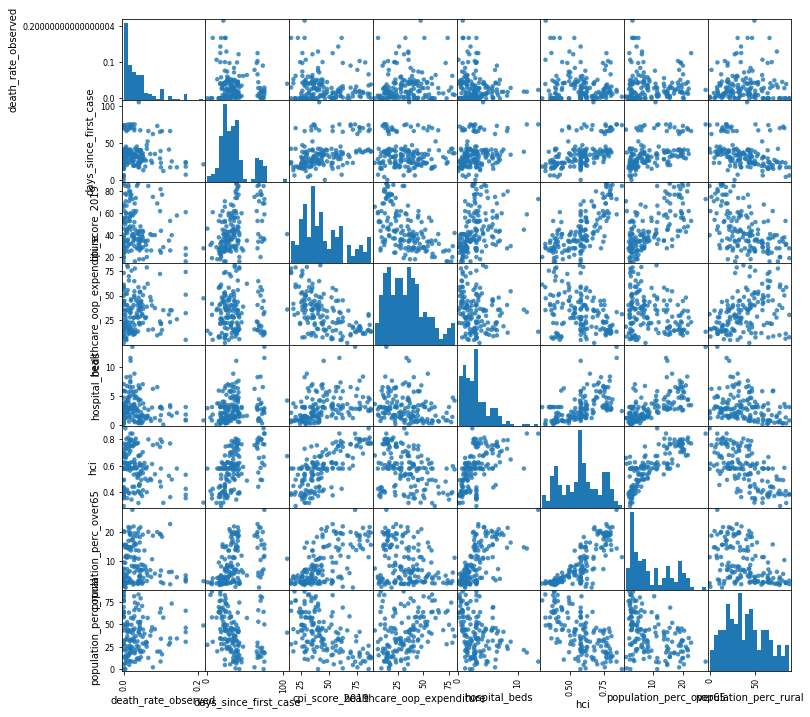

In [192]:
pairs = pd.plotting.scatter_matrix(df[df.columns[2::]], figsize=(12, 12),
                        hist_kwds={'bins': 20}, s=80, alpha=.8)

In [193]:
# Show the 15 countries with highest number of cases:
df.sort_values('cases', ascending=False).head(15)

,cases,deaths,death_rate_observed,days_since_first_case,cpi_score_2019,healthcare_oop_expenditure,hospital_beds,hci,population_perc_over65,population_perc_rural
Country/Region,,,,,,,,,,
US,366614,10783,0.029412,75,69.0,11.086677,2.900000,0.762,15.807654,17.744
Spain,136675,13341,0.097611,65,62.0,23.826371,3.000000,0.743,19.378508,19.679
Italy,132547,16523,0.124658,66,53.0,23.105705,3.400000,0.769,22.751680,29.562
Germany,103374,1810,0.017509,70,80.0,12.409593,8.300000,0.795,21.461962,22.688
France,98963,8926,0.090195,73,69.0,9.756244,6.500000,0.765,20.034625,19.556
Mainland China,82665,3335,0.040344,105,41.0,35.906185,4.200000,0.673,10.920884,40.848
Iran,60500,3739,0.061802,47,26.0,38.793717,1.500000,0.591,6.184574,25.102
United Kingdom,52279,5385,0.103005,66,77.0,15.117967,2.800000,0.781,18.395866,16.602
Turkey,30217,649,0.021478,26,39.0,16.466121,2.700000,0.626,8.483213,24.857


# Model

The approach here is to fit a hierarchical Bayes Binomial model on the case & death counts, while also controlling for the country-level covariates using a GLM with logit link function for the country-level mortality rates.

All model code (using pymc3) can be found in source/model.py.

### Mathematical description of model
For those desiring more detailed information about the model, please refer to the text below:
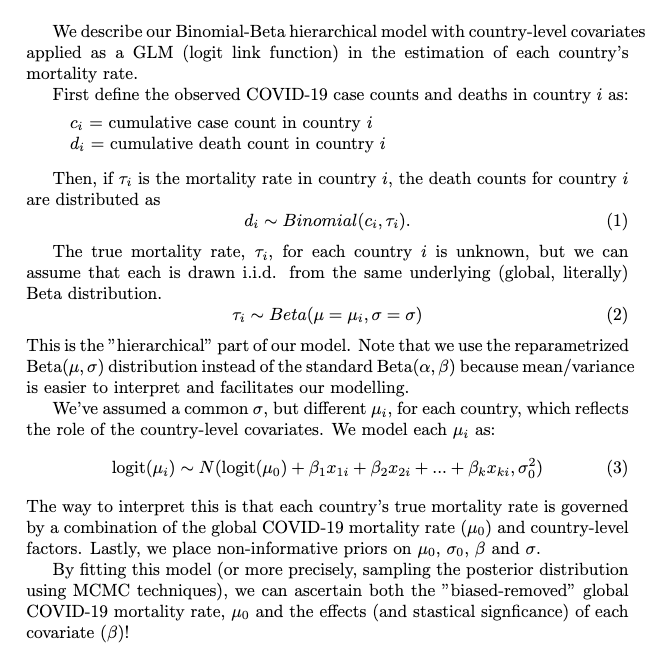

### A note about normalization
Critical to the interpretation of mu_0 as the "global, de-biased mortality rate" is that the individual covariates be normalized in a way that makes that interpretation valid. What I mean by this is that the case where all country-level covariates are equal to 0 should reflect a country whose individual mortality rate is "as close to the true global rate as we can expect."

With respect to the covariates that we used in this analysis, this translates to:

- "days since first case" - normalize so the highest value is zero. We want to know what the rates look like when the outbreak is fully mature.
- "cpi score" - normalize so the highest value is zero. The most transparent goverments should have the least biased rates.
- "healthcare oop expenditure" - normalize so the mean value is zero - to be agnostic to the affect of public vs. private healthcare systems.
- "hospital beds per capita" - normalize so the highest value is zero. More hospital beds likely means more access to care and testing.
- "HCI" - normalize so the highest value is zero. HCI is a proxy for quality of healthcare and education.
- "% population over 65" - normalize so mean value is zero, to reflect the world age demographic as closely as possible.
- "% population rural" - normalize so mean value is zero, to reflect the world urban/rural demographic as closely as possible.

In [194]:
# Initialize the model:
# import importlib
# importlib.reload(model)
mod = model.initialize_model(df)

In [195]:
# Run MCMC sampler
with mod:
    trace = pm.sample(2000, tune=10000,
                      chains=3, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [tau, mu_model_logit, sigma, beta, sig_0, mu_0]
Sampling 3 chains, 598 divergences: 100%|██████████| 36000/36000 [14:28<00:00, 41.45draws/s] 
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.65491032693553, but should be close to 0.8. Try to increase the number of tuning steps.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8854562942985686, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3cf40550>,
      dtype=object)

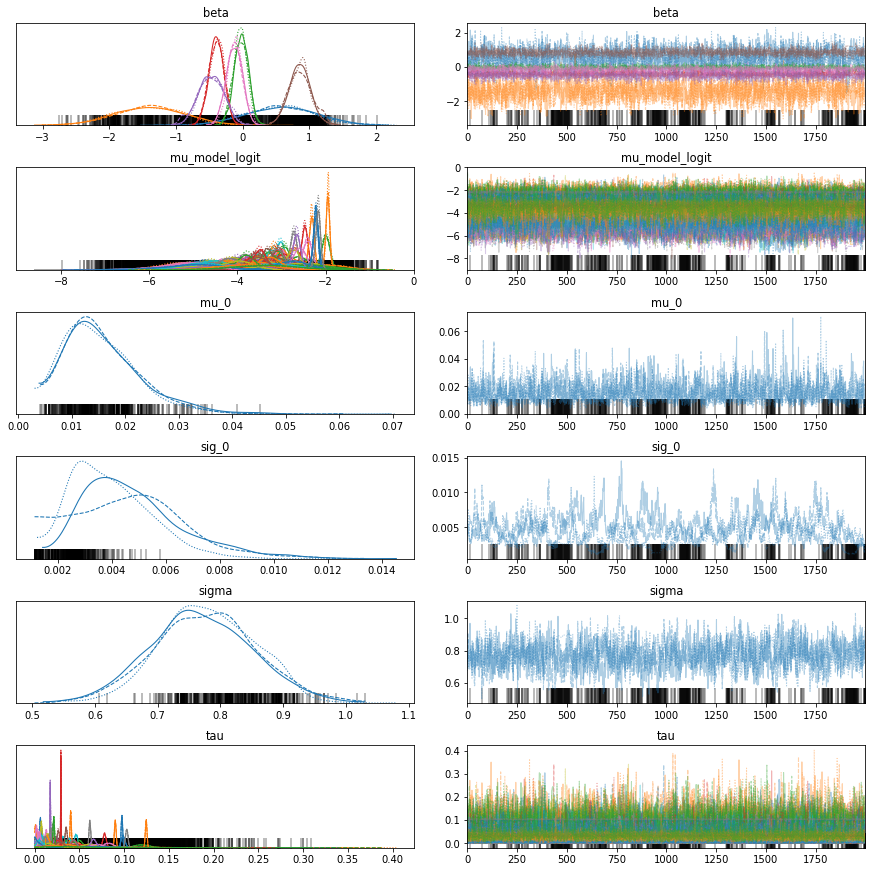

In [196]:
# Visualize the trace of the MCMC sampler to assess convergence
pm.traceplot(trace)

NameError: name 'plt' is not defined

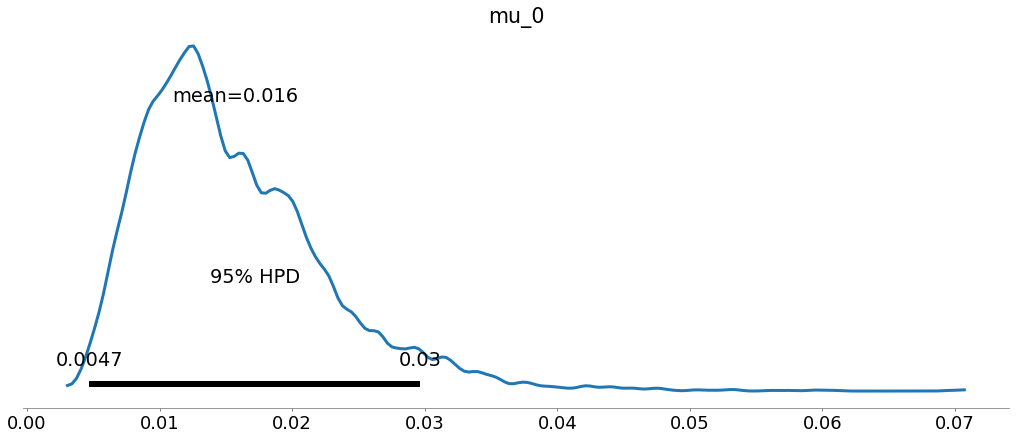

In [197]:
# Posterior plot for mu0
pm.plot_posterior(trace, var_names=['mu_0'], figsize=(14, 6), textsize=18,
                  credible_interval=0.95, bw=1.0, lw=3, kind='kde')
plt.xlim(0.0, 0.05)